In [167]:
%matplotlib inline 
import os 
import pandas as pd 
import numpy as np 
import nibabel as nb 
from nilearn import datasets
from nilearn.plotting.surf_plotting import load_surf_data, load_surf_mesh
from kanaan_surf import plot_surf_stat_all

ahba_dir       = '/scr/malta3/workspace/project_iron/AHBA'
freesurfer_dir = '/a/software/freesurfer/5.3.0/ubuntu-xenial-amd64/subjects'


# Read fsaverage data 

In [72]:
def return_fsaverage_data(freesurfer_dir, fsaverage_id):
    datadir = os.path.join(fs_dir, fsaverage_id, 'surf')
    
    fsaverage = dict()
    fsaverage['infl_left']  = os.path.join(datadir, 'lh.inflated')
    fsaverage['infl_right'] = os.path.join(datadir, 'rh.inflated')
    fsaverage['pial_left']  = os.path.join(datadir, 'lh.pial')
    fsaverage['pial_right'] = os.path.join(datadir, 'rh.pial')
    fsaverage['sulc_left']  = os.path.join(datadir, 'lh.sulc')
    fsaverage['sulc_right'] = os.path.join(datadir, 'rh.sulc')
    
    return fsaverage

fsaverage = return_fsaverage_data(freesurfer_dir, 'fsaverage')

In [65]:
def plot_surf_map(fsaverage,
                  surf_map_l,
                  surf_map_r,
                  threshold=None,
                  alpha=0.7,
                  cmap='hot',
                  output_file=None, title=None):
    
    # Import libraries
    import nibabel
    import numpy as np
    import matplotlib.pyplot as plt

    from mpl_toolkits.mplot3d import Axes3D
    from nibabel import gifti

    from nilearn._utils.compat import _basestring
    from nilearn.plotting.img_plotting import _get_colorbar_and_data_ranges
    from nilearn.plotting.surf_plotting import load_surf_data, load_surf_mesh


    
    
    # load mesh and derive axes limits
    mesh_left = load_surf_mesh(fsaverage['pial_left'])
    mesh_right = load_surf_mesh(fsaverage['pial_right'])

    coords_left, faces_left = mesh_left[0], mesh_left[1]
    coords_right, faces_right = mesh_right[0], mesh_right[1]

    limits = [-65, 33]

    avg_method = 'mean'
    darkness = 1

    # if no cmap is given, set to matplotlib default
    if cmap is None:
        cmap = plt.cm.get_cmap(plt.rcParamsDefault['image.cmap'])
    else:
        # if cmap is given as string, translate to matplotlib cmap
        if isinstance(cmap, _basestring):
            cmap = plt.cm.get_cmap(cmap)

    def subplot(surf_map, bg_map, subplot_id, coords, faces, elev, azim, vmin=None, vmax=None):

        bg_on_data = False

        ax = fig.add_subplot(subplot_id, projection='3d', xlim=limits, ylim=limits)
        ax.view_init(elev=elev, azim=azim)
        ax.set_axis_off()
        p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2], triangles=faces, linewidth=0.,
                                    antialiased=False, color='red')

        # If depth_map and/or surf_map are provided, map these onto the surface
        # set_facecolors function of Poly3DCollection is used as passing the
        # facecolors argument to plot_trisurf does not seem to work
        if bg_map is not None or surf_map is not None:

            face_colors = np.ones((faces.shape[0], 4))
            # face_colors[:, :3] = .5*face_colors[:, :3]  # why this?

            if bg_map is not None:
                bg_data = load_surf_data(bg_map)
                if bg_data.shape[0] != coords.shape[0]:
                    raise ValueError('The bg_map does not have the same number '
                                     'of vertices as the mesh.')
                bg_faces = np.mean(bg_data[faces], axis=1)
                bg_faces = bg_faces - bg_faces.min()
                bg_faces = bg_faces / bg_faces.max()
                # control background darkness
                bg_faces *= darkness
                face_colors = plt.cm.gray_r(bg_faces)

            # modify alpha values of background
            face_colors[:, 3] = alpha * face_colors[:, 3]
            # should it be possible to modify alpha of surf data as well?

            if surf_map is not None:
                surf_map_data = surf_map  # load_surf_data(surf_map)
                if len(surf_map_data.shape) is not 1:
                    raise ValueError('surf_map can only have one dimension but has'
                                     '%i dimensions' % len(surf_map_data.shape))
                if surf_map_data.shape[0] != coords.shape[0]:
                    raise ValueError('The surf_map does not have the same number '
                                     'of vertices as the mesh.')

                # create face values from vertex values by selected avg methods
                if avg_method == 'mean':
                    surf_map_faces = np.mean(surf_map_data[faces], axis=1)
                elif avg_method == 'median':
                    surf_map_faces = np.median(surf_map_data[faces], axis=1)

                # if no vmin/vmax are passed figure them out from data
                if vmin is None:
                    vmin = np.nanmin(surf_map_faces)
                if vmax is None:
                    vmax = np.nanmax(surf_map_faces)

                # treshold if inidcated
                if threshold is None:
                    kept_indices = np.where(surf_map_faces)[0]
                else:
                    kept_indices = np.where(np.abs(surf_map_faces) >= threshold)[0]

                surf_map_faces = surf_map_faces - vmin
                surf_map_faces = surf_map_faces / (vmax - vmin)

                # multiply data with background if indicated
                if bg_on_data:
                    face_colors[kept_indices] = cmap(surf_map_faces[kept_indices]) \
                                                * face_colors[kept_indices]
                else:
                    face_colors[kept_indices] = cmap(surf_map_faces[kept_indices])

            p3dcollec.set_facecolors(face_colors)

    fig = plt.figure(figsize=(55, 20))

    subplot(surf_map_l, fsaverage['sulc_left'], 141, coords_left, faces_left, elev=0, azim=180)
    subplot(surf_map_l, fsaverage['sulc_left'], 142, coords_left, faces_left, elev=0, azim=0)
    subplot(surf_map_r, fsaverage['sulc_right'], 143, coords_right, faces_right, elev=0, azim=180)
    subplot(surf_map_r, fsaverage['sulc_right'], 144, coords_right, faces_right, elev=0, azim=0)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    # save figure if output file is given
    if output_file is not None:
        fig.savefig(output_file)
        plt.close(fig)
        # else:
        #    return fig


# read parcellation data

In [73]:
parc_lh = '/scr/malta2/TOURETTOME/FS_SUBJECTS/PNASWhitaker/fsaverageSubP/label/lh.500.aparc.annot'
parc_rh = '/scr/malta2/TOURETTOME/FS_SUBJECTS/PNASWhitaker/fsaverageSubP/label/rh.500.aparc.annot'
parc_lh_labels, parc_lh_ctab, parc_lh_names = nb.freesurfer.read_annot(parc_lh)
parc_rh_labels, parc_rh_ctab, parc_rh_names = nb.freesurfer.read_annot(parc_rh)



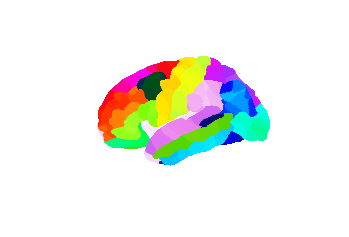

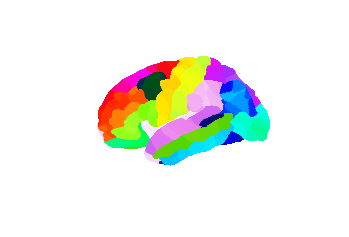

In [79]:
from nilearn import plotting
plotting.plot_surf_roi(load_surf_mesh(fsaverage['pial_left']), 
                       roi_map=parc_lh_labels,
                       hemi='left', 
                       view='lateral',
                       bg_on_data=True,
                       darkness=.5, cmap='gist_ncar')

In [84]:
len(parc_lh_labels)

163842

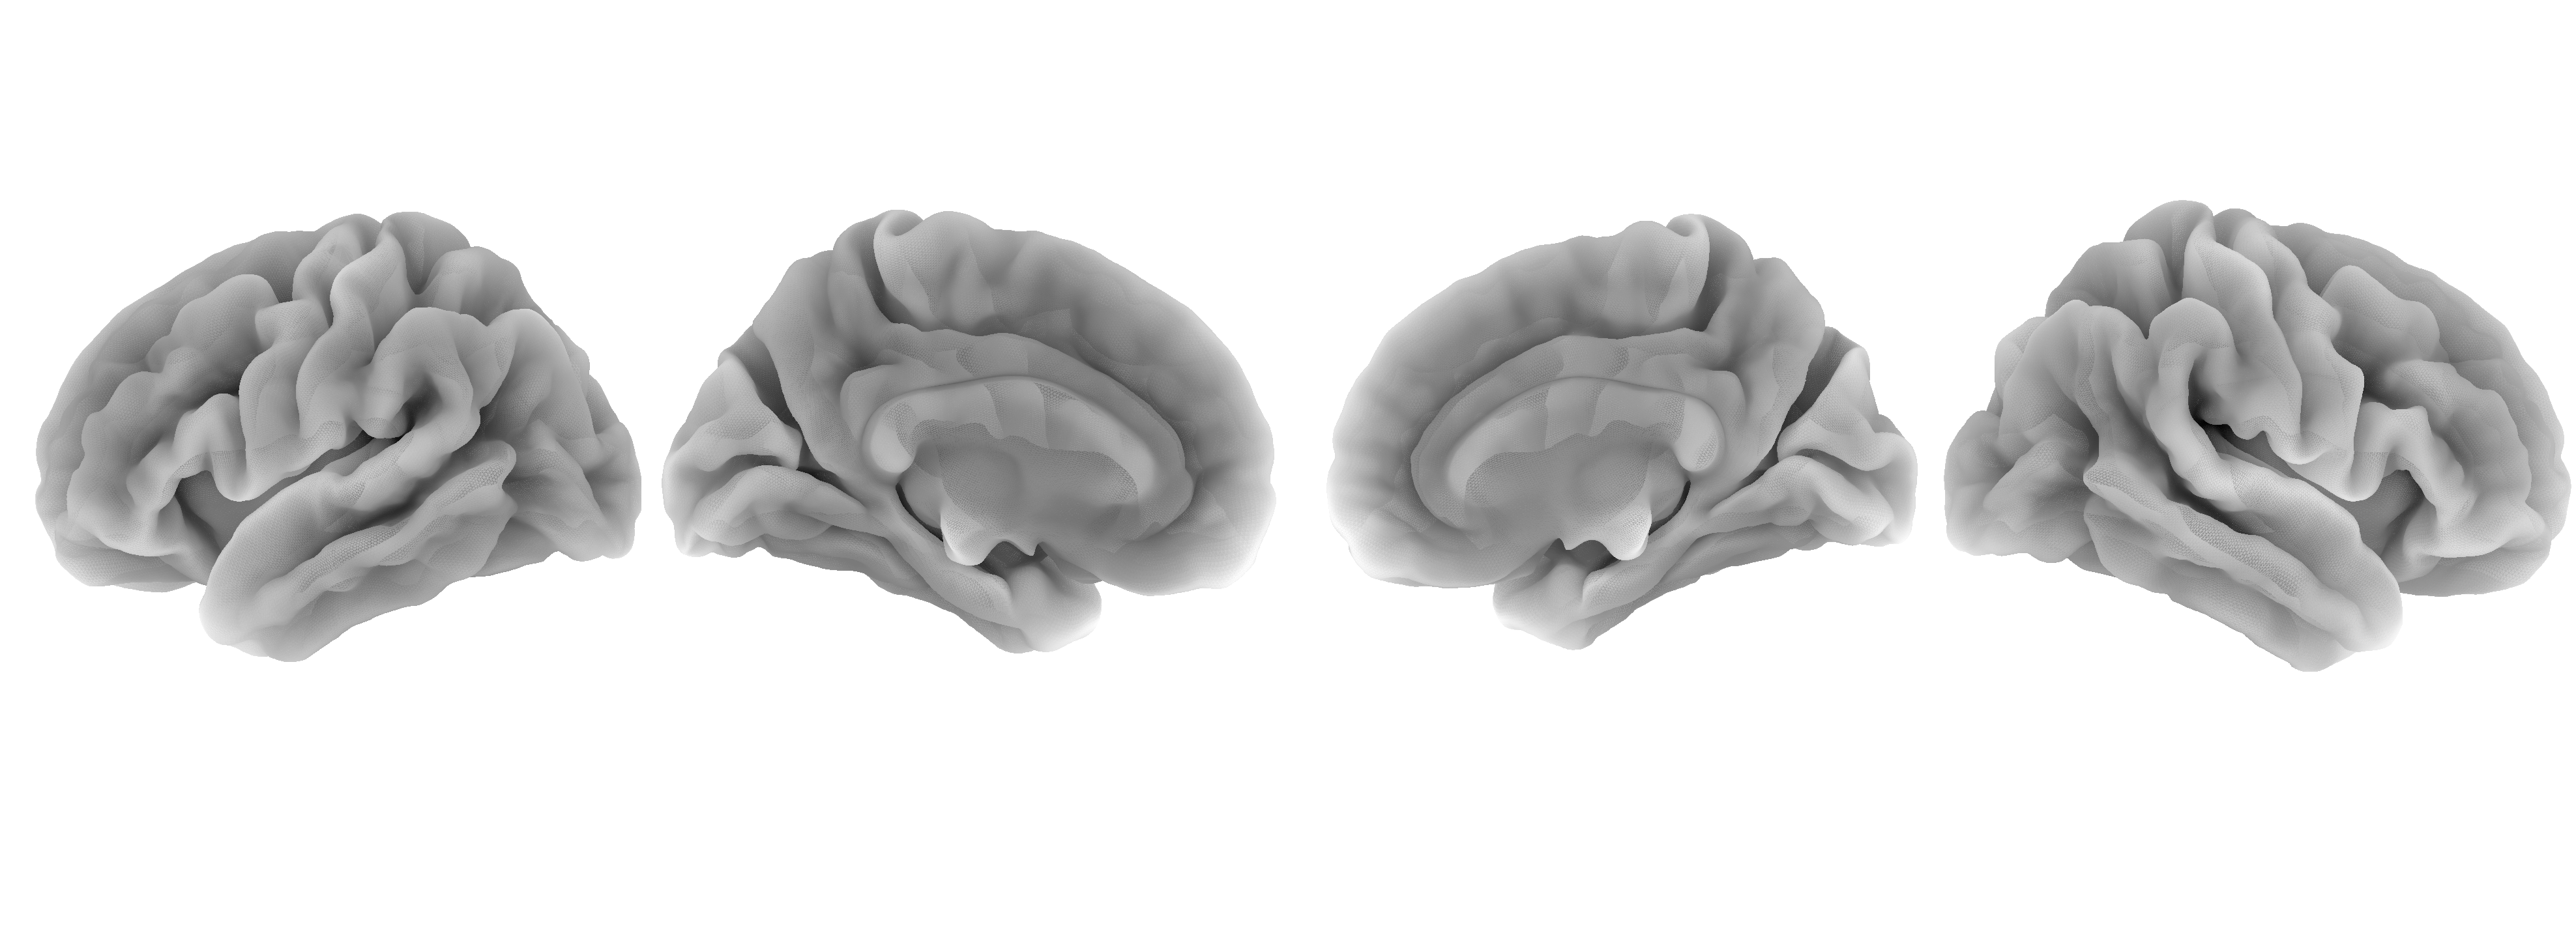

In [80]:
plot_surf_gene_expression(fsaverage, None, None)

In [193]:
open('/scr/malta2/TOURETTOME/FS_SUBJECTS/PNASWhitaker/fsaverageSubP/parcellation/500.names.txt').readlines()

['Left-Cerebral-White-Matter\r\n',
 'Left-Lateral-Ventricle\r\n',
 'Left-Inf-Lat-Vent\r\n',
 'Left-Cerebellum-White-Matter\r\n',
 'Left-Cerebellum-Cortex\r\n',
 'Left-Thalamus-Proper\r\n',
 'Left-Caudate\r\n',
 'Left-Putamen\r\n',
 'Left-Pallidum\r\n',
 '3rd-Ventricle\r\n',
 '4th-Ventricle\r\n',
 'Brain-Stem\r\n',
 'Left-Hippocampus\r\n',
 'Left-Amygdala\r\n',
 'CSF\r\n',
 'Left-Accumbens-area\r\n',
 'Left-VentralDC\r\n',
 'Left-vessel\r\n',
 'Left-choroid-plexus\r\n',
 'Right-Cerebral-White-Matter\r\n',
 'Right-Lateral-Ventricle\r\n',
 'Right-Inf-Lat-Vent\r\n',
 'Right-Cerebellum-White-Matter\r\n',
 'Right-Cerebellum-Cortex\r\n',
 'Right-Thalamus-Proper\r\n',
 'Right-Caudate\r\n',
 'Right-Putamen\r\n',
 'Right-Pallidum\r\n',
 'Right-Hippocampus\r\n',
 'Right-Amygdala\r\n',
 'Right-Accumbens-area\r\n',
 'Right-VentralDC\r\n',
 'Right-vessel\r\n',
 'Right-choroid-plexus\r\n',
 'WM-hypointensities\r\n',
 'Optic-Chiasm\r\n',
 'CC_Posterior\r\n',
 'CC_Mid_Posterior\r\n',
 'CC_Central\r\n',

# Get Parcellation centroids

In [311]:
parc500_cent  = pd.read_csv('/scr/malta2/TOURETTOME/FS_SUBJECTS/PNASWhitaker/fsaverageSubP/parcellation/500.centroids.txt', header = None)
parc500_names =  pd.read_csv('/scr/malta2/TOURETTOME/FS_SUBJECTS/PNASWhitaker/fsaverageSubP/parcellation/500.names.txt', header = None)
parc500  = pd.concat([parc500_names, parc500_cent], axis = 1)
parc500.columns=['Name', 'Centroid']
#parc500 = parc500.drop(range(41), axis = 0)
parc500

,Name,Centroid
0,Left-Cerebral-White-Matter,-27.965157 -19.013702 17.919528
1,Left-Lateral-Ventricle,-14.455663 -13.693461 13.713674
2,Left-Inf-Lat-Vent,-33.906934 -22.284672 -15.821168
3,Left-Cerebellum-White-Matter,-17.305373 -53.431573 -36.017154
4,Left-Cerebellum-Cortex,-22.265823 -64.366296 -37.674831
5,Left-Thalamus-Proper,-11.752497 -19.875842 5.165738
6,Left-Caudate,-15.034188 9.437552 6.913427
7,Left-Putamen,-26.366197 -0.156863 -2.091549
8,Left-Pallidum,-20.916714 -5.188669 -2.410765
9,3rd-Ventricle,0.583205 -11.116950 -3.943328


In [63]:
AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_DB.csv'),index_col = 0 )
AHBA['PARC500'] = ''

In [312]:
AHBA.head()

,61E3.4,A1BG,A1CF,A26C1B,A2BP1,A2LD1,A2M,A2ML1,A3GALT2P,A4GALT,...,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,donor,PARC500
594,12.257452,4.307083,1.639045,6.047821,11.502535,2.992096,7.702302,4.657058,1.675294,3.470479,...,"paracentral lobule, anterior part, right, infe...",37470,87,52,116,5.9,-27.7,49.7,donor1,rh_paracentral_part1
2985,12.971966,5.394092,2.016619,6.258501,12.314500,3.450627,8.285363,5.044534,3.596557,4.651128,...,"claustrum, right",40517,66,92,63,29.2,17.0,-2.9,donor1,rh_insula_part1
2801,13.397286,6.196477,2.419608,5.442959,12.776440,3.652065,8.698773,4.777458,3.662503,4.845015,...,"claustrum, right",41516,66,81,104,28.2,-22.8,16.8,donor1,rh_insula_part2
2273,13.326607,5.665946,2.473735,4.363560,12.428296,4.512593,9.333068,5.325190,2.956374,3.377773,...,"dorsal lateral geniculate nucleus, left",41473,116,94,101,-24.6,-24.6,1.3,donor1,lh_insula_part1
2785,13.356659,5.087975,2.391748,4.590116,13.365749,3.558010,9.939992,5.247008,3.760852,4.446860,...,"CA4 field, right",41142,63,104,106,31.1,-31.3,-7.3,donor1,rh_parahippocampal_part1


In [326]:
from operator import itemgetter

for well in AHBA.index:
    # get well MNI coords
    ahba_coords = tuple([AHBA.loc[well]['mni_x'], AHBA.loc[well]['mni_y'], AHBA.loc[well]['mni_z']])
    #print 'AHBA=', well, coords
    
    # calculate euclidian distance between well mni coordinates and parc_500 centroids
    euc = [euclidean(ahba_coords, [float(d) for d in parc500.loc[parc]['Centroid'].split()]) for parc in parc500.index]
    
    #find name of centroid with minumum euclidian distance to well coordinates
    parc_min_well_dist =  min(enumerate(euc), key=itemgetter(1))[0]  #+ 41
    
    #print 'PARC=', parc_min_well_dist, parc500.loc[parc_min_well_dist]['Name'], parc500.loc[parc_min_well_dist]['Centroid']
    
    # append parcellation name to AHBA dataframe
    AHBA.loc[well, 'PARC500'] = parc500.loc[parc_min_well_dist]['Name']

In [327]:
AHBA#['structure_name']

,61E3.4,A1BG,A1CF,A26C1B,A2BP1,A2LD1,A2M,A2ML1,A3GALT2P,A4GALT,...,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,donor,PARC500
594,12.257452,4.307083,1.639045,6.047821,11.502535,2.992096,7.702302,4.657058,1.675294,3.470479,...,"paracentral lobule, anterior part, right, infe...",37470,87,52,116,5.9,-27.7,49.7,donor1,rh_paracentral_part1
2985,12.971966,5.394092,2.016619,6.258501,12.314500,3.450627,8.285363,5.044534,3.596557,4.651128,...,"claustrum, right",40517,66,92,63,29.2,17.0,-2.9,donor1,rh_insula_part1
2801,13.397286,6.196477,2.419608,5.442959,12.776440,3.652065,8.698773,4.777458,3.662503,4.845015,...,"claustrum, right",41516,66,81,104,28.2,-22.8,16.8,donor1,Right-Cerebral-White-Matter
2273,13.326607,5.665946,2.473735,4.363560,12.428296,4.512593,9.333068,5.325190,2.956374,3.377773,...,"dorsal lateral geniculate nucleus, left",41473,116,94,101,-24.6,-24.6,1.3,donor1,WM-hypointensities
2785,13.356659,5.087975,2.391748,4.590116,13.365749,3.558010,9.939992,5.247008,3.760852,4.446860,...,"CA4 field, right",41142,63,104,106,31.1,-31.3,-7.3,donor1,rh_parahippocampal_part1
2793,14.097546,5.008133,1.631623,6.620493,13.778565,2.772909,7.269222,5.572003,2.566058,2.372902,...,"dentate gyrus, right",41141,63,104,107,31.1,-32.3,-7.1,donor1,rh_parahippocampal_part1
2795,12.257307,5.771079,2.250821,6.101249,10.237291,4.092093,9.906851,5.482967,3.656102,4.070411,...,"dentate nucleus, left",73345,101,130,123,-9.7,-57.4,-32.6,donor1,Left-Cerebellum-White-Matter
2787,12.429456,5.773837,2.431591,4.686517,9.948550,3.902574,9.179340,5.207539,4.069870,4.138006,...,"fastigial nucleus, left",75936,90,127,125,1.9,-58.4,-28.7,donor1,4th-Ventricle
2874,12.739914,6.181961,2.398844,6.204205,9.657435,3.787046,9.935296,4.731728,3.828880,4.654104,...,"emboliform nucleus, right",56000,84,125,118,8.5,-50.3,-27.8,donor1,4th-Ventricle
2858,12.043521,5.013767,1.947309,6.272927,11.775498,2.128210,7.709195,4.939403,2.194948,4.038434,...,"subiculum, left",41212,114,108,100,-22.6,-27.4,-13.8,donor1,Left-Hippocampus


In [323]:
AHBA.columns[-14:]

Index([u'structure_id', u'slab_num', u'slab_type', u'structure_acronym',
       u'structure_name', u'polygon_id', u'mri_voxel_x', u'mri_voxel_y',
       u'mri_voxel_z', u'mni_x', u'mni_y', u'mni_z', u'donor', u'PARC500'],
      dtype='object')

In [325]:
AHBA.loc[594]['structure_acronym']

'PCLa-i'

In [256]:
for parc in parc500.index:
    print 

[-56.40355, -40.152663, 1.708876]
[-53.140506, -49.843038, 8.264557]
[-5.001684, 20.645903, 25.733446]
[-33.265925, 20.200202, 45.347826]
[-31.958115, 2.146597, 51.26911]
[-38.795007, 12.584757, 33.278581]
[-39.715079, 11.341351, 48.846438]
[-8.609127, -73.360119, 17.095238]
[-5.3042, -87.102157, 19.323496]
[-24.010774, -5.86141, -32.826641]
[-30.237677, -46.493585, -17.452397]
[-34.771765, -9.299608, -35.172549]
[-33.515847, -72.220765, -14.257923]
[-37.632472, -38.758481, -22.9063]
[-38.896698, -60.874682, -16.663844]
[-43.393728, -58.809524, 40.471545]
[-35.980519, -83.125541, 18.926407]
[-44.904486, -56.280753, 17.439942]
[-31.993691, -75.483701, 33.056782]
[-43.132353, -66.558824, 15.90625]
[-37.122661, -69.533264, 43.258836]
[-43.26638, -75.049409, 23.400644]
[-45.069149, -64.283245, 32.022606]
[-43.614049, -6.016575, -40.149171]
[-50.245499, -60.608838, -7.837971]
[-48.242567, -19.479656, -32.479656]
[-52.185499, -51.758004, -16.904896]
[-52.818271, -31.30943, -26.385069]
[-52.8

In [87]:
parc_lh_ctab

array([[     109,       68,      192,      255, 12600429],
       [     229,      186,      104,      255,  6863589],
       [     240,       65,      136,      255,  8929776],
       [     244,       68,       64,      255,  4211956],
       [     237,       17,       76,      255,  4985325],
       [     151,       52,      162,      255, 10630295],
       [     204,      128,      166,      255, 10911948],
       [     203,       59,      153,      255, 10042315],
       [      28,      132,      214,      255, 14058524],
       [     235,      127,       71,      255,  4685803],
       [     167,      234,      130,      255,  8579751],
       [     249,       50,       28,      255,  1848057],
       [      76,      101,      107,      255,  7038284],
       [      79,      177,       23,      255,  1552719],
       [     102,       75,       78,      255,  5131110],
       [      27,      152,       72,      255,  4757531],
       [      39,        0,       72,      255,  4718631

In [8]:
fsaverage
8etghw

In [94]:
coords, faces= nb.freesurfer.read_geometry(fsaverage['pial_left'])

In [97]:
coords

array([[-38.83454895, -19.01935577,  66.90840912],
       [-16.55412674, -69.25585175,  60.97793579],
       [ -9.55357552,  -8.21880722,  46.25186157],
       ..., 
       [-34.57094193, -24.75985909, -26.42899132],
       [-34.64751053, -24.71244431, -25.72299576],
       [-35.07868576, -24.7596302 , -25.22186661]])

In [98]:
faces

array([[     0,  40964,  40962],
       [     0,  40962,  40965],
       [     0,  40965,  40967],
       ..., 
       [163841, 160926,  39990],
       [163113, 160926, 163841],
       [163113,     11, 160926]], dtype=int32)